In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor     # μπορεί να μείνει, δεν θα το χρησιμοποιήσεις
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#  Load final clustering data (K-means) 
data_path = "../data/Clustering/Clustering_Data.csv"
ts_daily = pd.read_csv(data_path)

# Build date from start_time
ts_daily["start_time"] = pd.to_datetime(ts_daily["start_time"])
ts_daily = ts_daily[ts_daily["start_time"].dt.year == 2018].copy()
ts_daily["date"] = ts_daily["start_time"].dt.floor("D")  # only date (without time)

# Build generic cluster_id from start_cluster_20
ts_daily = ts_daily.rename(columns={"start_cluster_20": "cluster_id"})

# 3) Sort values by cluster_id and date
ts_daily = ts_daily.sort_values(["cluster_id", "date"]).reset_index(drop=True)

ts_daily.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,cluster_id,end_cluster_20,date
0,79.0,40.719116,-74.006667,276.0,40.717488,-74.010455,31170,1,1,2018-01-01 11:29:51.339,2018-01-01 11:32:01.416,2.17,48,0,0,2018-01-01
1,79.0,40.719116,-74.006667,249.0,40.718710,-74.009001,33302,1,1,2018-01-01 17:21:59.786,2018-01-01 17:23:40.417,1.67,26,0,0,2018-01-01
2,79.0,40.719116,-74.006667,302.0,40.720828,-73.977932,27199,1,1,2018-01-01 18:09:31.030,2018-01-01 18:26:21.160,16.83,25,0,15,2018-01-01
3,79.0,40.719116,-74.006667,3002.0,40.711512,-74.015756,33084,1,1,2018-01-01 18:23:27.462,2018-01-01 18:31:15.818,7.80,54,0,0,2018-01-01
4,79.0,40.719116,-74.006667,249.0,40.718710,-74.009001,26424,1,1,2018-01-01 18:40:15.336,2018-01-01 18:54:13.156,13.95,48,0,0,2018-01-01


In [3]:
# Keep a copy of the cleaned 2018 trips
data_2018 = ts_daily.copy()

# Define the K-means clusters we care about
highlight_clusters = [2, 3, 15]

# Create an hourly timestamp from start_time
data_2018["start_time"] = pd.to_datetime(data_2018["start_time"])
data_2018["hour"] = data_2018["start_time"].dt.floor("H")

# Keep trips that start OR end in the selected clusters
time_series_data = data_2018[
    (data_2018["cluster_id"].isin(highlight_clusters)) |
    (data_2018["end_cluster_20"].isin(highlight_clusters))
].copy()

time_series_data.head()

C:\Users\Georg\AppData\Local\Temp\ipykernel_21812\2128651030.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_2018["hour"] = data_2018["start_time"].dt.floor("H")


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,cluster_id,end_cluster_20,date,hour
2,79.0,40.719116,-74.006667,302.0,40.720828,-73.977932,27199,1,1,2018-01-01 18:09:31.030,2018-01-01 18:26:21.160,16.83,25,0,15,2018-01-01,2018-01-01 18:00:00
7,79.0,40.719116,-74.006667,3427.0,40.724305,-73.996010,31170,1,1,2018-01-01 22:05:53.223,2018-01-01 22:12:29.444,6.60,52,0,15,2018-01-01,2018-01-01 22:00:00
10,82.0,40.711174,-74.000165,350.0,40.715595,-73.987030,15495,1,1,2018-01-01 20:32:22.073,2018-01-01 20:49:52.197,17.50,38,0,15,2018-01-01,2018-01-01 20:00:00
19,152.0,40.714740,-74.009106,151.0,40.722104,-73.997249,30858,1,1,2018-01-01 18:03:29.910,2018-01-01 18:12:31.678,9.02,29,0,15,2018-01-01,2018-01-01 18:00:00
27,195.0,40.709056,-74.010434,151.0,40.722104,-73.997249,26020,1,1,2018-01-01 11:28:55.067,2018-01-01 11:43:29.866,14.57,52,0,15,2018-01-01,2018-01-01 11:00:00


In [4]:
# Build pickup dataset: trips starting in the cluster
pickup_df = time_series_data[["cluster_id", "hour"]].copy()
pickup_df["pickups"] = 1
pickup_df["dropoffs"] = 0

# Build dropoff dataset: trips ending in the cluster
dropoff_df = time_series_data[["end_cluster_20", "hour"]].copy()
dropoff_df = dropoff_df.rename(columns={"end_cluster_20": "cluster_id"})
dropoff_df["pickups"] = 0
dropoff_df["dropoffs"] = 1

# Combine pickups and dropoffs into one table
ts_raw = pd.concat([pickup_df, dropoff_df], axis=0)

# Derive calendar date and hour-of-day
ts_raw["date"] = ts_raw["hour"].dt.date
ts_raw["hour_of_day"] = ts_raw["hour"].dt.hour

# Keep only selected clusters (2, 3, 15)
ts_raw = ts_raw[ts_raw["cluster_id"].isin(highlight_clusters)].copy()

ts_raw.head()

,cluster_id,hour,pickups,dropoffs,date,hour_of_day
2474977,2,2018-01-01 01:00:00,1,0,2018-01-01,1
2474978,2,2018-01-01 11:00:00,1,0,2018-01-01,11
2474979,2,2018-01-01 12:00:00,1,0,2018-01-01,12
2474980,2,2018-01-01 12:00:00,1,0,2018-01-01,12
2474981,2,2018-01-01 01:00:00,1,0,2018-01-01,1


In [5]:
# Daily pickups per cluster and hour
ts_daily_pickups = ts_raw.pivot_table(
    index=["cluster_id", "date"],
    columns="hour_of_day",
    values="pickups",
    aggfunc="sum",
    fill_value=0
)
ts_daily_pickups = ts_daily_pickups.rename(
    columns={h: f"pick_{h}" for h in ts_daily_pickups.columns}
)

# Daily dropoffs per cluster and hour
ts_daily_dropoffs = ts_raw.pivot_table(
    index=["cluster_id", "date"],
    columns="hour_of_day",
    values="dropoffs",
    aggfunc="sum",
    fill_value=0
)
ts_daily_dropoffs = ts_daily_dropoffs.rename(
    columns={h: f"drop_{h}" for h in ts_daily_dropoffs.columns}
)

# Merge pickups and dropoffs into a single daily table
ts_daily = (
    ts_daily_pickups.reset_index()
    .merge(ts_daily_dropoffs.reset_index(), on=["cluster_id", "date"], how="left")
)

ts_daily = ts_daily.fillna(0)

# Clean up index name if any
ts_daily.columns.name = None

ts_daily.head()


,cluster_id,date,pick_0,pick_1,pick_2,pick_3,pick_4,pick_5,pick_6,pick_7,...,drop_14,drop_15,drop_16,drop_17,drop_18,drop_19,drop_20,drop_21,drop_22,drop_23
0,2,2018-01-01,9,10,9,8,1,1,3,0,...,39,24,20,15,20,13,12,9,7,6
1,2,2018-01-02,1,2,1,0,1,6,23,35,...,43,35,42,77,102,70,50,28,20,12
2,2,2018-01-03,4,2,2,0,1,7,28,59,...,40,52,53,81,103,105,74,41,26,7
3,2,2018-01-04,5,2,1,0,0,6,7,7,...,3,3,0,5,11,3,3,3,1,0
4,2,2018-01-05,3,0,0,0,0,0,5,11,...,15,10,10,25,20,26,12,7,4,1


In [6]:
# Make sure date is datetime
ts_daily = ts_daily.reset_index(drop=True)
ts_daily["date"] = pd.to_datetime(ts_daily["date"])

# Calendar features
ts_daily["day_of_week"] = ts_daily["date"].dt.dayofweek
ts_daily["is_weekend"] = (ts_daily["day_of_week"] >= 5).astype(int)

# Hourly pickup/dropoff columns
pick_cols = [f"pick_{h}" for h in range(24)]
drop_cols = [f"drop_{h}" for h in range(24)]
hour_cols = pick_cols + drop_cols

# Next-day targets (shift -1 within each cluster)
shifted = ts_daily.groupby("cluster_id")[hour_cols].shift(-1)
shifted.columns = [f"target_{c}" for c in hour_cols]
ts_daily = pd.concat([ts_daily, shifted], axis=1)

# Lag 1 day
lag1 = ts_daily.groupby("cluster_id")[hour_cols].shift(1)
lag1.columns = [f"lag1_{c}" for c in hour_cols]
ts_daily = pd.concat([ts_daily, lag1], axis=1)

# Rolling 3-day mean
roll3 = (
    ts_daily
    .groupby("cluster_id")[hour_cols]
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)
roll3.columns = [f"roll3_{c}" for c in hour_cols]
ts_daily = pd.concat([ts_daily, roll3], axis=1)

# Remove rows with NaNs created by shifting/rolling
ts_daily = ts_daily.dropna().copy()

ts_daily.head()


,cluster_id,date,pick_0,pick_1,pick_2,pick_3,pick_4,pick_5,pick_6,pick_7,...,roll3_drop_14,roll3_drop_15,roll3_drop_16,roll3_drop_17,roll3_drop_18,roll3_drop_19,roll3_drop_20,roll3_drop_21,roll3_drop_22,roll3_drop_23
2,2,2018-01-03,4,2,2,0,1,7,28,59,...,40.666667,37.000000,38.333333,57.666667,75.000000,62.666667,45.333333,26.000000,17.666667,8.333333
3,2,2018-01-04,5,2,1,0,0,6,7,7,...,28.666667,30.000000,31.666667,54.333333,72.000000,59.333333,42.333333,24.000000,15.666667,6.333333
4,2,2018-01-05,3,0,0,0,0,0,5,11,...,19.333333,21.666667,21.000000,37.000000,44.666667,44.666667,29.666667,17.000000,10.333333,2.666667
5,2,2018-01-06,4,3,1,1,0,1,2,3,...,13.333333,10.333333,9.333333,15.333333,12.000000,13.333333,7.666667,4.000000,2.666667,1.666667
6,2,2018-01-07,6,2,4,0,1,0,2,2,...,20.333333,18.666667,19.666667,22.000000,19.000000,18.000000,12.000000,7.333333,5.666667,4.666667


In [7]:
# Train / test split by date
train_daily = ts_daily[ts_daily["date"] < "2018-11-01"].copy()
test_daily  = ts_daily[ts_daily["date"] >= "2018-11-01"].copy()

print("Train rows:", len(train_daily))
print("Test rows:", len(test_daily))

# Feature and target columns
feature_cols = (
    ["day_of_week", "is_weekend"]
    + [f"lag1_{c}" for c in hour_cols]
    + [f"roll3_{c}" for c in hour_cols]
)

target_cols = [f"target_{c}" for c in hour_cols]


Train rows: 906
Test rows: 180


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_eval_linear_for_cluster(cluster_id):
    """
    Train and evaluate a multi-output Linear Regression model
    for one cluster (next-day 24h pickups + 24h dropoffs).
    Prints MAE and RMSE for pickups and dropoffs and
    plots the last test day.
    """

    # Filter rows for this cluster
    train_c = train_daily[train_daily["cluster_id"] == cluster_id].copy()
    test_c  = test_daily[test_daily["cluster_id"] == cluster_id].copy()

    if len(train_c) == 0 or len(test_c) == 0:
        print(f"[WARN] Cluster {cluster_id}: no train or test data.")
        return None

    X_train = train_c[feature_cols].values
    y_train = train_c[target_cols].values
    X_test  = test_c[feature_cols].values
    y_test  = test_c[target_cols].values

    # Linear Regression baseline (multi-output)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    n_pick = len(pick_cols)

    # Split predictions and ground truth into pickups and dropoffs
    y_true_pick = y_test[:, :n_pick].ravel()
    y_pred_pick = y_pred[:, :n_pick].ravel()

    y_true_drop = y_test[:, n_pick:].ravel()
    y_pred_drop = y_pred[:, n_pick:].ravel()

    rmse_pick = np.sqrt(mean_squared_error(y_true_pick, y_pred_pick))
    mae_pick  = mean_absolute_error(y_true_pick, y_pred_pick)

    rmse_drop = np.sqrt(mean_squared_error(y_true_drop, y_pred_drop))
    mae_drop  = mean_absolute_error(y_true_drop, y_pred_drop)

    print(f"\nCluster {cluster_id} – Linear Regression")
    print(f"Pickups  : RMSE = {rmse_pick:.3f}, MAE = {mae_pick:.3f}")
    print(f"Dropoffs : RMSE = {rmse_drop:.3f}, MAE = {mae_drop:.3f}")

    # Plot last test day (24h)
    last_true = y_test[-1]
    last_pred = y_pred[-1]

    true_pick = last_true[:n_pick]
    pred_pick = last_pred[:n_pick]

    true_drop = last_true[n_pick:]
    pred_drop = last_pred[n_pick:]

    hours = np.arange(n_pick)

    # Pickups plot
    plt.figure(figsize=(14, 4))
    plt.plot(hours, true_pick, "-o", label="True pickups")
    plt.plot(hours, pred_pick, "-o", label="Predicted pickups")
    plt.title(f"Cluster {cluster_id} – Next-day pickups (last test day)")
    plt.xlabel("Hour")
    plt.ylabel("Trips")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Dropoffs plot
    plt.figure(figsize=(14, 4))
    plt.plot(hours, true_drop, "-o", label="True dropoffs")
    plt.plot(hours, pred_drop, "-o", label="Predicted dropoffs")
    plt.title(f"Cluster {cluster_id} – Next-day dropoffs (last test day)")
    plt.xlabel("Hour")
    plt.ylabel("Trips")
    plt.grid(True)
    plt.legend()
    plt.show()

    return {
        "rmse_pick": rmse_pick,
        "mae_pick": mae_pick,
        "rmse_drop": rmse_drop,
        "mae_drop": mae_drop,
    }



Cluster 2 – Linear Regression
Pickups  : RMSE = 47.084, MAE = 32.280
Dropoffs : RMSE = 46.761, MAE = 31.752


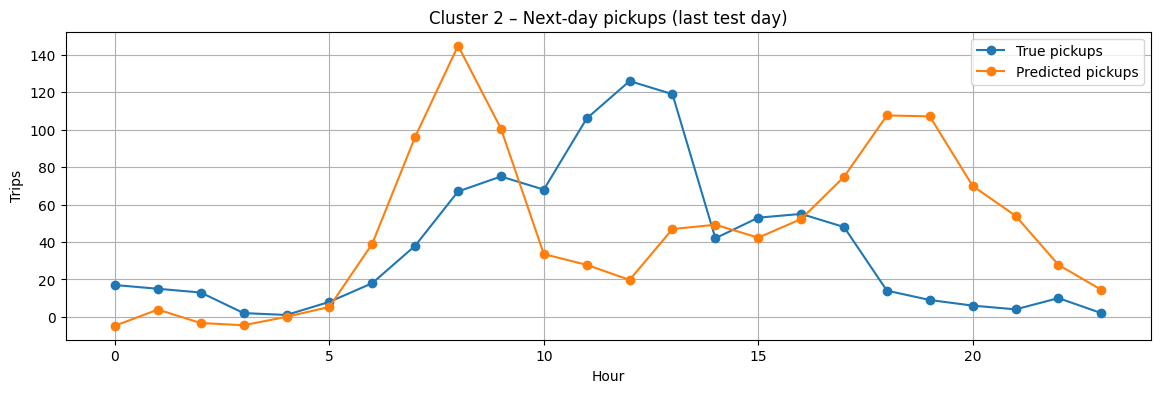

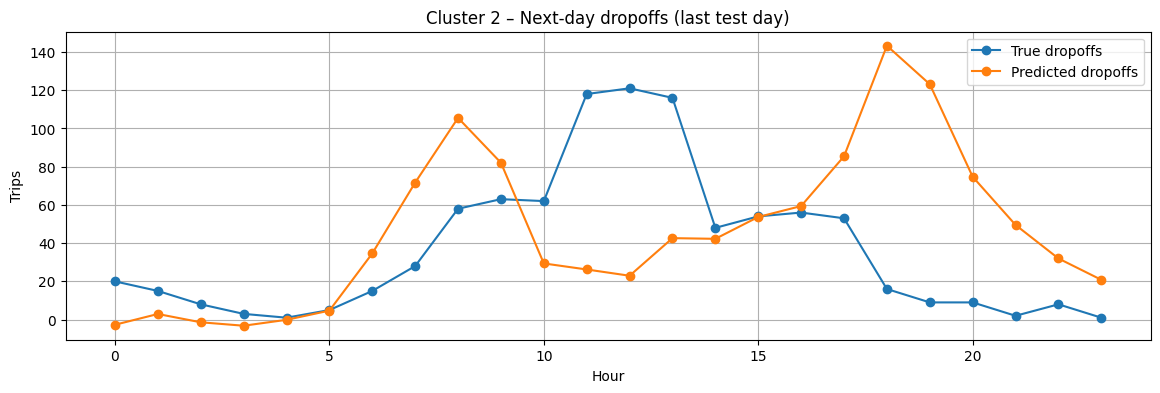


Cluster 3 – Linear Regression
Pickups  : RMSE = 41.134, MAE = 25.948
Dropoffs : RMSE = 42.333, MAE = 26.432


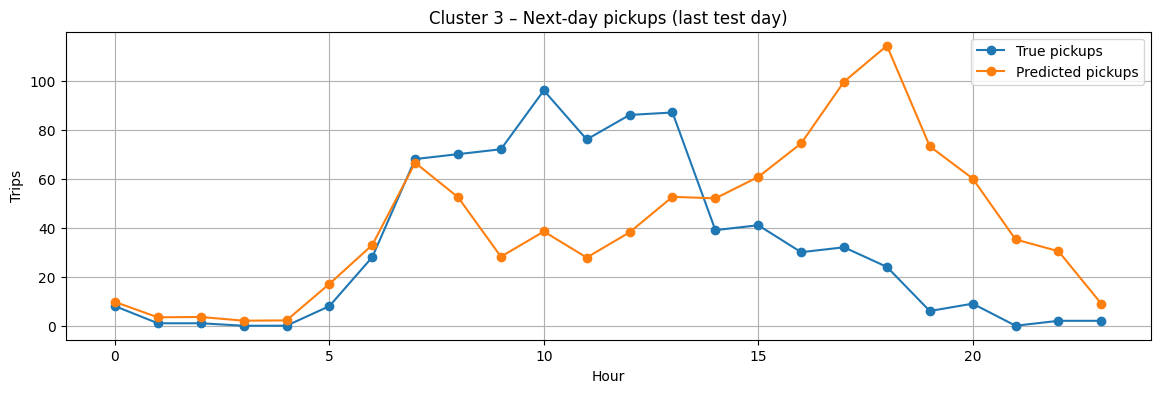

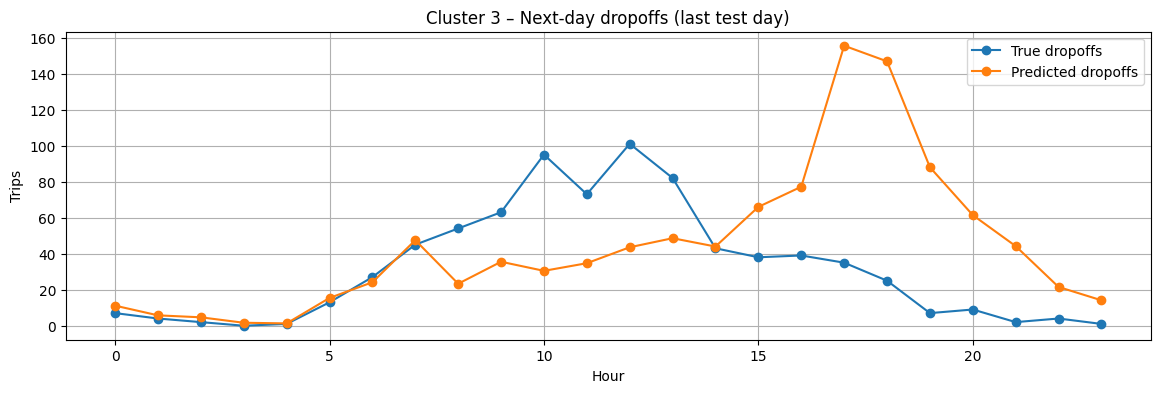


Cluster 15 – Linear Regression
Pickups  : RMSE = 102.828, MAE = 66.965
Dropoffs : RMSE = 104.349, MAE = 65.771


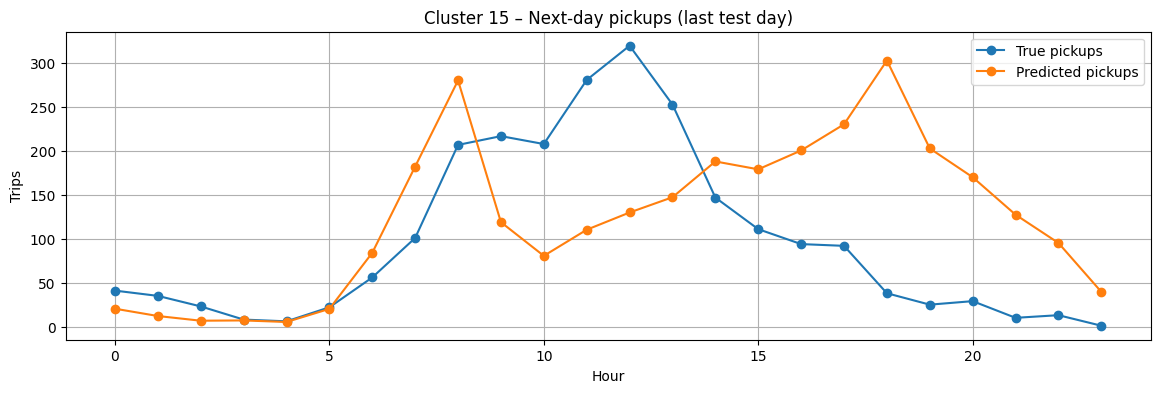

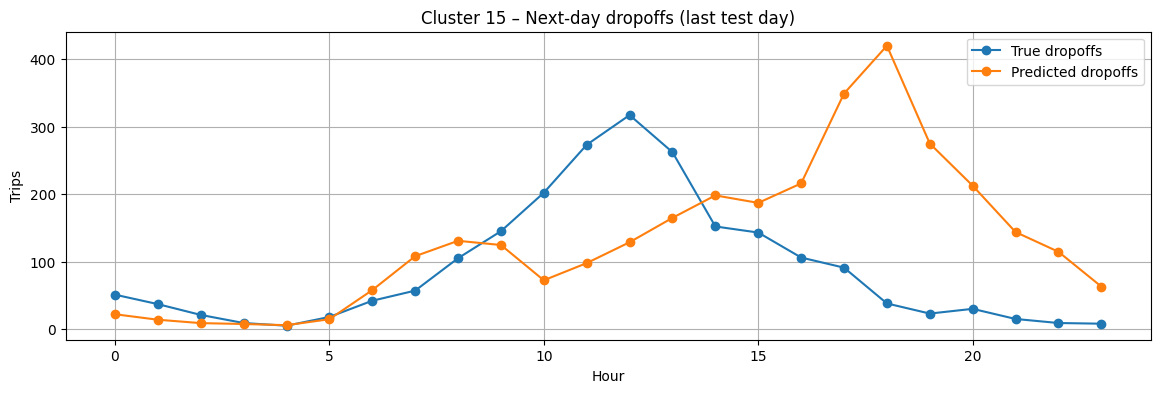

{2: {'rmse_pick': np.float64(47.08421059827991),
  'mae_pick': 32.280091623024,
  'rmse_drop': np.float64(46.76098822445093),
  'mae_drop': 31.752440831688},
 3: {'rmse_pick': np.float64(41.134432070226794),
  'mae_pick': 25.948431675549156,
  'rmse_drop': np.float64(42.3333858027637),
  'mae_drop': 26.431750671154685},
 15: {'rmse_pick': np.float64(102.82770730101929),
  'mae_pick': 66.96491053426699,
  'rmse_drop': np.float64(104.34883526253682),
  'mae_drop': 65.77050595758536}}

In [9]:
results_linear = {}

for cid in [2, 3, 15]:
    res = train_eval_linear_for_cluster(cid)
    results_linear[cid] = res

results_linear
